# Practical 3A: Reinforcement Learning

© Deep Learning Indaba. Apache License 2.0.

Adapted for Khipu by Diego de Las Casas and José Lezama

## Introduction

In this practical, we will cover the basics of reinforcement learning, which has successfully been used to [control robotic hands](https://openai.com/blog/learning-dexterity/); play [Chess](https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go), [Go](https://en.wikipedia.org/wiki/AlphaGo), and [StarCraft](https://deepmind.com/blog/article/alphastar-mastering-real-time-strategy-game-starcraft-ii). It can even be used for supervised learning problems. For example, training a neural net to optimize a non-differentiable objective (such as accuracy, or the [BLEU score in machine translation](https://arxiv.org/abs/1609.08144)) or [finding a good neural net architecture](https://arxiv.org/abs/1611.01578) for a particular supervised learning problem.

## Learning Objectives

* Understand the problem reinforcement learning tries to solve.
* Understand the terminology used in reinforcement learning: **environment**, **action**, **observation**, **reward**, **agent**,  **policy**, **episode**.
* Learn how to use the [OpenAI Gym](https://gym.openai.com/) reinforcement learning environments.
* Learn how to solve the classic reinforcement learning problem of balancing a pole on a moving cart using Random Search and Policy Gradients. Understand some of the limitations of these methods.

**IMPORTANT: Please fill out the exit ticket form before you leave the practical: https://tinyurl.com/yxjvqx5k**


## Imports

In [0]:
#@title Imports (RUN ME!)


# Note: enviroments like CartPole-v0 require a display to render. We need to install pyvirtualdisplay etc 
# in order to render from these environments

!pip install pyglet~=1.3.2 > /dev/null 2>&1
!pip install 'gym[atari]' > /dev/null 2>&1
!apt-get install python-opengl -y > /dev/null 2>&1
!apt install xvfb -y > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install tensorflow==2.0.0-beta0 > /dev/null 2>&1

from IPython.display import HTML

# Start virtual display
from pprint import pprint
import logging
from pyvirtualdisplay import Display
logging.getLogger("pyvirtualdisplay").setLevel(logging.ERROR)

display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

## The Reinforcement Learning Problem

So far we have encountered **supervised learning**, where we have an input and a target value or class that we want to predict. We have also encountered **unsupervised learning**, where we are only given an input and look for patterns in that input. In this practical, we look into **reinforcement learning**, which can loosely be defined as training an **agent** to maximise the total **reward** it obtains through many interactions with an **environment**.

At timestep $t$, the agent can make an **observation** of the environment $o_t$. For example, if the environment is a computer game, the observation could be the pixel values of the current screen.

The environment defines a set of **actions** that an agent can take.  The agent performs an action $a_t$ informed by the observations it has made, and will receive a **reward** $r_t$ from the environment after every action. The *reinforcement learning problem* is to find an agent whose actions maximize the total rewards obtained from the environment over many actions.

The following diagram illustrates the interaction between the agent and environment. We will explore each of the terms in more detail throughout this practical.

<!-- ![Interaction of Agent and Environment](https://github.com/sbodenstein/Tutorials/blob/master/indaba_2019/Images/RL_Environment.png?raw=true) -->

<img src="https://raw.githubusercontent.com/sbodenstein/Tutorials/master/indaba_2019/Images/RL_Environment.png" alt="drawing" width=600/>



**Optional Recommended Reading**: 
- [*OpenAI Spinning Up: Key Concepts in RL*](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) is a great summary of the terminology used in reinforcement learning. 

### The Environment

We will focus on the cartpole environment for this practical. This environment consists of a pole attached to a cart via a hinge, with the pole initially balanced close to upright. The agent needs to move the cart to the left or to the right in order to prevent the pole from falling over.

![CartPole Illustration](https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif)


We will use the OpenAI Gym implementation of the cartpole environment. [OpenAI Gym](https://gym.openai.com/) is probably the most popular set of reinforcement learning environments (the available environments in Gym can be seen [here](https://gym.openai.com/envs)). Every Gym environment has the same interface, allowing code written for one environment to work for all of them. Popular reinforcement learning frameworks, such as [Ray](https://ray.readthedocs.io/en/latest/index.html), often use the Gym interface as [their default interface](https://ray.readthedocs.io/en/latest/rllib-env.html#openai-gym) for reinforcement learning environments.

Let us import Gym and open a cartpole environment:

In [0]:
import numpy as np
import gym
env_cartpole = gym.make('CartPole-v1')

The first step to using a Gym environment is to initialize the environment to some initial configuration using the `reset` method. The `reset` method also returns the first observation of the environment:

In [0]:
env_cartpole.reset()

array([ 0.02282044,  0.04924642,  0.0497842 , -0.02586221])

These four numbers represent the position and velocity of the cart and pole, `(cart position, cart velocity, pole angle, velocity of the top of the pole)`. We will want our agent to use this observation when deciding to move left or right. 

We also want to see an image of the system that we can interpret. Gym provides the `render` method to do this:

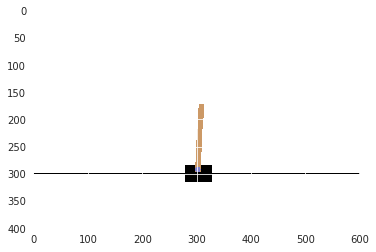

In [0]:
import matplotlib.pyplot as plt
plt.imshow(env_cartpole.render(mode='rgb_array'));

Note that reinitializing this environment with `reset` will randomly change the starting angle of the pole. By running this multiple times, see if you can notice this:

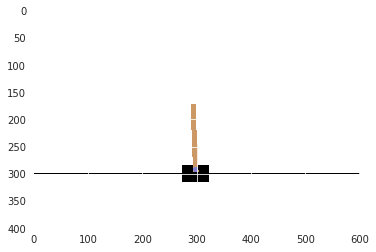

In [0]:
env_cartpole.reset()
plt.imshow(env_cartpole.render(mode='rgb_array'));

Now we want to take an action using the `step` method. But which actions are allowed, and how are they represented? We can find this out using the `action_space` property of Gym environments:

In [0]:
env_cartpole.action_space

Discrete(2)

In Gym, `Discrete(n)` means actions are represented by the integers `0,1,...,n-1`. Action spaces always provide a way to take a random action sampled from the space:

In [0]:
[env_cartpole.action_space.sample() for _ in range(10)]

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0]

Now let us take an action using the `step` method, which takes an action and returns a tuple `(observation, reward, done, info)`:

In [0]:
action = 1
env_cartpole.step(action)

(array([-0.01353183,  0.15115776, -0.03940272, -0.26397129]), 1.0, False, {})

**Question**: Does the action `0` move the cart to the left or to the right? Use the `step` and `render` methods to figure this out.


What is `done`? Many environments are **episodic**, which means they have a natural end-point, after which more actions cannot be taken. For example in chess, the game ends after a checkmate. In the case of cart-pole, this end-point is when the pole falls down too far. Then no matter the actions taken, the pole will keep falling. Gym will set `done` as `True` in this case, and will print a warning if `step` is called again. The `reset` method needs to be called to reinitialize the environment when `done` is `True`.  We won't use `info` (see the [official Gym docs](https://gym.openai.com/docs/#observations) for more information).

In addition, many Gym environments have a maximum number of steps they can take, after which `done` is set to `True`. This can be seen using the `_max_episode_steps` property:



In [0]:
env_cartpole._max_episode_steps

500

**Question**: What is an appropriate reward for a game of chess? Suppose the environment is one where your agent plays against an existing chess-playing computer. Remember that there are three outcomes in chess, a win, loss and draw.

#### Question

Write a function `actions_till_done(env, act)` that takes an environment `env` and action `act`, reinitializes `env` with `reset`, and returns the number of actions taken before `done` is `True`. If you always take the `0` action, how many steps can you take on average before `done` is `True`?

Reveal the cell below by double-clicking and running it, to check your answer when you're done or you get stuck!

In [0]:
#@title Answer { display-mode: "form" }
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env_cartpole, 0) for _ in range(100)])

9.24

## Agents and Policies

A **policy** is a function used by an agent to decide what actions to take. This function takes as input an observation and returns either an action (a **deterministic policy**) or a probability distribution over possible actions (a **stochastic policy**).

**Note**: the terms **policy** and **agent** are often used interchangeably:
> Because the policy is essentially the agent’s brain, it’s not uncommon to substitute the word “policy” for “agent”, e.g. saying “The policy is trying to maximize reward.” ~ [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#policies)

We will consider an **agent** to be a function whose input is the observation, and it returns a dictionary which always contains the `"Action"` key. It might also contain other keys, such as the action probabilities, the value function, etc. 

The simplest possible policy for a cartpole agent is one that always takes the `0` action, no matter what the observation is:

In [0]:
def agent_left(observation):
    return {"Action":0}

In [0]:
agent_left(None)

{'Action': 0}

## Rewards and Returns

Recall that in Reinforcement Learning, the **reward** is a scalar signal that the agent observes upon acting on the environment and which it will try to maximize. In the cartpole example, a reward of **+1** is provided for every timestep that the pole remains upright (less than 15 degrees from the vertical). 

Is our agent `agent_left` any good? To answer that, we need some measure of 'goodness', which is usually related to the total return obtained during an episode. This is called the **return**, $R$, and there are different ways of defining it. The most obvious definition for return is to simply add up all the rewards the agent received during an episode. If the episode took $T$ steps, and got a reward $r_t$ at each step, then this return is $R = \sum_{t=1}^{T} r_{t}$, where $r_t$ is the reward received at timestep $t$.

One issue is that some environments will have different initial states, agents may take actions stochastically and the rewards themselves could be stochastic. The solution is to average the returns over multiple starting points. Here is a function that does this:

In [0]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

Now we can see how good our agent `agent_left` is:

In [0]:
average_episodic_return(env_cartpole, agent_left)

{'AverageEpisodicReturn': 9.3, 'StandardDeviation': 0.6403124237432849}

## Animating Agents

This code cell defines a function `animate_agent(environment, agent)` that produces a human understandable animation of the `agent` controlling the `environment`. **Note:** It is not necessary to understand these functions to follow this practical.

In [0]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

Now we can easily get an animation of the cartpole environment controlled by `policy_left`:

In [0]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env_cartpole, agent_left)

## Agent 1: Random Action Agent

Rather than having an agent whose policy is to always take the same action, we could also randomly choose between possible actions

**Question**: would you expect the agent taking random actions to get a higher or lower return than the `agent_left` agent for cartpole?

In [0]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

**Note**: that we can easily write a general random agent for any gym environment using `env.action_space.sample()`. 

Computing the average return of `agent_random`:

In [0]:
average_episodic_return(env_cartpole, agent_random)

{'AverageEpisodicReturn': 24.8, 'StandardDeviation': 16.73200525938239}

And animating it:

In [0]:
animate_agent(env_cartpole, agent_random)

### Random Agent Tasks

1. [**ALL**] Create a random agent for "MsPacman-v0" environment using `env.action_space.sample()` and animate the agent using `animate_agent` for 300 steps.



## Agent 2: Neural Net Policy Trained with Random Search

To improve on the random agent `agent_random`, we need a policy that takes the observation of the environment into account. In this section, we will show how to create an agent that solves the cartpole problem without any fancy reinforcement learning methods.

First, define an agent with a single hidden-layer multi-layer perceptron (MLP) policy implemented using NumPy. Its input is a vector of length 4 and its output is either `0` or `1`:

In [0]:
class AgentMLPNumpy:
    def __init__(self, num_hidden):
        self.W1 = np.random.randn(num_hidden, 4)
        self.W2 = np.random.randn(2, num_hidden)
        
    def __call__(self, x):
        y = self.W1.dot(x)
        y = np.tanh(y)
        y = self.W2.dot(y)
        return {"Action":np.argmax(y)}

The reate an instance of `AgentMLPNumpy` (with random weight initializations), and compute its return. If the return is better than previous agents, then keep this agent. Otherwise, throw it away and try a new randomly initialized agent `AgentMLPNumpy`. Repeat this process `n` times.

### Random Search Tasks

1. [**ALL**] Write a function `find_good_mlp_agent(env, num_tries, mlp_size)` that tries `num_tries` instances of `AgentMLPNumpy`, each with different weights. It should return both the agent that got the best return, along with that return.
2. [**All**] Try out different values of `num_tries` and `mlp_size` until you find values that produces an agent getting a return of 500. **Hint**: `num_tries` shouldn't need to be larger than 300.
3. [**ALL**] Visualize your best agent controlling cartpole using `animate_agent`.

### Extra Reading on Random Search

Variations of random search have proven to be very succesful for training agents to solve the reinforcement learning problem. Here are some examples:
- [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/blog/evolution-strategies/), OpenAI, 2017
- [Simple random search provides a competitive approach to reinforcement learning](https://arxiv.org/abs/1803.07055), H. Mania *et al*, 2018
- [Welcoming the Era of Deep Neuroevolution](https://eng.uber.com/deep-neuroevolution/), Uber AI Labs, 2017

Note that random search used to solve the *reinforcement learning problem* is not generally considered to be a *reinforcement learning method* (as implied by the titles of some of the readings above, eg. "Evolution Strategies as a Scalable Alternative to Reinforcement Learning"). The reason for this:

> Reinforcement learning, like many topics whose names end with “ing,” such as machine learning and mountaineering, is simultaneously a problem, a class of solution methods that work well on the problem, and the field that studies this problem and its solution methods. It is convenient to use a single name for all three things, but at the same time essential to keep the three conceptually separate. In particular, the distinction between problems and solution methods is very important in reinforcement learning; failing to make this distinction is the source of many confusions. ~ *Reinforcement Learning*, Sutton and Barto, **2nd Edition**

## Agent 3: Neural Net Agent Trained with Policy Gradients

Unlike the random policy, the MLP policy trained with random search *does* take environment observations into account when choosing to take an action. However, the training procedure is clearly not optimal: each policy in the search makes no use of observations and rewards seen by previous policies. For environments where it takes significant time and money to take actions and make observations (for example, a real robot picking strawberries), this is incredibly wasteful. In this section, we present a method that does take previous observations into account when learning.

**Warning**: This section requires more mathematics than previous sections, and hence more precise notation. It will thus be significantly more abstract.

### Policy Gradient Theory

As we saw earlier, the reinforcement learning problem is to find an agent/policy that maximizes the return (rewards). We will now use a neural net to represent a stochastic policy  $\pi_\mathbf{\theta}(a_t|o_t)$, where $\mathbf{\theta}$ is the set of learnable parameters in the neural net, and $\pi_\mathbf{\theta}(a_t|o_t)$ is a probability distribution over the possible actions conditioned on the observation.

A **trajectory**  $\tau$ is a sequence of observations of the environment and the corresponding actions an agent takes. For an episodic task that ends after $T$ steps:
$$\tau = (o_0, a_0, o_1, a_1, \ldots , o_T, a_T)$$
The return (or total rewards) is a function of the trajectory, $R(\tau)$.

We want to find the values of $\theta$ that maximize the **expected return** over trajectories:
$$J(\pi_\theta)= \mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}[R(\tau)]$$

The usual way of efficiently finding good values of $\theta$ is to differentiate the objective with respect to $\theta$ and then use gradient descent. Luckily, we can obtain an *estimate* of this gradient. The key result is the *Policy Gradient Theorem*, which says that you can evaluate the gradient using the gradients of the policy itself:
$$\nabla_\theta J(\pi_\theta) = 
\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}\left[ \sum_{t=0}^{T}\Phi_t\nabla_\theta\log \pi_\theta(a_t|o_t) \right] 
$$
There are many possibilities for $\Phi_t$ (see page 2 [here](https://arxiv.org/pdf/1506.02438.pdf) for a list of these possibilities). We  will use $\Phi_t = \hat{R}_t \equiv \sum_{t'=t}^{T} r_{t'}$, sometimes known as the [reward-to-go](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you). Note that $\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}$ is an expectation over trajectories $\tau$ which can be estimated by using a sample mean. Let us call this estimate of the gradient $\hat{g}$:

$$\hat{g} = \frac{1}{|D|}\sum_{\tau \in \mathcal{D}}
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|o_t) 
$$
where $\mathcal{D}$ is a set of trajectories of size $|\mathcal{D}|$. The more trajectories we sample from, the lower the variance of the estimator $\hat{g}$. But to simplify things for this practical, we will only be sampling from only one trajectory at a time to get our gradient estimate. Then:
$$\hat{g} =
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|o_t) 
$$
Translating this into a loss to be *maximized*:
$$\mathcal{L}=\sum_{t=0}^{T}\hat{R}_t\log \pi_\theta(a_t|o_t) $$

This looks very similar to the usual supervised learning cross-entropy loss, $\sum_{i}\log p(y_i|x_i) $, where $y_i$ is the label and $x_i$ is the feature. Indeed, learning with policy gradients is almost the same doing supervised learning with the following small changes:

- we use the action $a_t$ taken when we saw $o_t$ as the label ($y_i$)
- the loss of each example gets multiplied (or *weighted*) by $\hat{R}_t$. This increases the log probability for good actions and decrease it by bad actions.
- we are doing gradient *ascent* rather than the usual gradient *descent*
- the observations $o_t$ are correlated with each other, and hence are not independent and identically distributed (i.i.d) as the features $x_i$ are assumed to be. 

In summary:

| Reinforcement Learning         	|  Supervised Learning 	|
|-------------------------------------	|-----------------------------------------------------		|
|  $\sum_{t}\log \pi_\theta(a_t|o_t) \hat{R}_t$     	| $\sum_{i}\log p(y_i|x_i) $    |
|  action $a_t$    | label $y_i$    |
|  observation $o_t$    | feature $x_i$    |
| $\pi_\theta(a_t|o_t)$   |   $p(y_i|x_i)$  |
|  gradient ascent     	|  gradient descent    |
| non-i.i.d observations $o_t$ | i.i.d features $x_i$

For those interested in the derivation, there are two excellent resources:
- [Part 3: Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) of OpenAI Spinning Up. Note that they often use *state* where we used *observation*.
- Chapter 13 of Sutton and Barto, *Reinforcement Learning: and Introduction*, 2nd Edition. A free copy can be found [here](http://incompleteideas.net/book/RLbook2018.pdf).

**Historical Note**: The name "policy gradient" comes from the fact that we're directly taking the gradient of the policy. The particular flavour of policy gradient which uses the loss function above, along with the Monte-carlo approximation of the objective is known as the **REINFORCE** algorithm ([Williams 1992](https://link.springer.com/article/10.1007/BF00992696)).


#### Optional extra reading: More on Policy Gradients

This section is for the mathematically inclined, and gives more insight into the Policy Gradient Theorem.

Outside of the reinforcement learning setting, the Policy Gradient Theorem is known as a [score function estimator](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/):
$$
\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)]=\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x;\theta)]
$$

The power of this theorem comes from the ability to estimate the RHS, even if $f(x)$ is a *black-box function* (i.e. one for which we don't have the analytical form for). We can do this by replacing the mean by the sample mean:
$$\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x;\theta)] 
\approx \frac{1}{N}\sum_{n=1}^{N}  f(\hat{x}^{(n)})\frac{\partial }{\partial \theta}\log p(\hat{x}^{(n)};\theta)$$

where $\hat{x}^{(n)}$ is sampled from $p(x;\theta)$. In the reinforcement learning setting, $x$ is the action sampled from the parameterized policy $p(x;\theta)$, and $f(x)$ is the reward function.

The derivation of the score function estimator:
$$
\begin{align}
\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)] 
&= \frac{\partial }{\partial \theta} \int p(x; \theta)f(x) \, dx \\ 
&= \int  \frac{\partial }{\partial \theta} p(x; \theta)f(x) \, dx \\ 
&= \int  p(x; \theta) \frac{\partial }{\partial \theta} \log p(x; \theta)f(x) \, dx \ \ \ \text{ (Log-Derivative trick)}\\ 
&= \mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x;\theta)]
\end{align}
$$

The Log-Derivative trick used in the third line is the property, for any function $f(x)$:
$$\frac{d f(x)}{dx}=\frac{f(x)}{f(x)}\frac{d f(x)}{dx}=f(x)\frac{d\log(f(x))}{dx}
$$ 
The right-hand side was obtained using the chain rule and the fact that $d \log(x)/dx=1/x$. 

The score function estimator is valid under **very** general conditions: $p(x;\theta)$ needs to be a continuous function of $\theta$, but does not need to be a continuous function of $x$. Furthermore, $f(x)$ can be discontinuous and $x$ can be either a discrete or continuous random variable (a reference for these conditions is [here](https://arxiv.org/abs/1506.05254)). This should reassure us when using this theorem for reinforcement learning, as it means we don't need to worry about showing that our environments produce a smooth or even continuous return function (which might not be true, or might be very hard to show for most environments)!




**Example: A Toy Model**

To get some intuition for how the score function estimator works, lets consider a toy model: Let $f(x)=-(x-k)^2$ (where $k$ is some real number) and let $p(x;\mu,\sigma)$ be normally distributed $\mathcal{N}(\mu, \sigma)$ with mean $\mu$ and variance $\sigma$:
$$
p(x;\mu,\sigma) = \frac{e^{-\frac{1}{2\sigma} (x-\mu)^2}}{\sqrt{2 \pi } \sigma}
$$

In reinforcement learning, the task is to find the values of $\mu$ and $\sigma$ that maximize $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$. Here is a summary as to how this toy problem fits into the reinforcement learning framework:

|     Reinforcement Learning Concept    	|  Toy Example 	|
|-------------------------------------	|-----------------------------------------------------		|
|  Action     	| choice of $x$    |
|  Policy    | $p(x;\mu,\sigma)$    |
|  Observation $o_t$     | None    |
| Reward $r_t$   |   $-(x-k)^2$  |


Unlike the general reinforcement learning case where $f(x)$ is a black-box,  we can analytically evaluate $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$ with our example:
$$
\begin{align}
\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]
&= \int^{\infty}_{-\infty} f(x) p(x;\mu,\sigma) dx \\
&=\int^{\infty}_{-\infty} \left[-(x-k)^2\right] \left[\frac{e^{-\frac{1}{2\sigma} (x-\mu)^2}}{\sqrt{2 \pi } \sigma}\right]dx \\
&=-(k-\mu)^2 - \sigma^2
\end{align}
$$

The maximimum of $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$ is when the distribution $p(x;\mu,\sigma)$ has mean $\mu=k$ (which corresponds to the position of the maximum of $f(x)=-(x-k)^2$) and variance $\sigma=0$ (so it is infinitely 'spiked', i.e. a [Dirac Delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)). This makes sense: to maximize $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$, we want all of the probability mass of $p(x;\mu,\sigma)$ to be concentrated at the maximum of $f(x)=-(x-k)^2$, i.e. $x=k$.

We can now also easily verify that using the score function estimator is equivalent to differentiating $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$ directly: as we have computed $
\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$, we immediately have that 
$$\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)] = \frac{\partial }{\partial \mu}\left[-((\mu-k)^2 + \sigma^2)\right]=2(k-\mu)
$$
But using the score function estimator instead:
$$\begin{align}
\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)] 
&= \mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)\frac{\partial }{\partial \mu}\log p(x;\mu,\sigma)] \\
&= \mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[-(x-k)^2 \frac{\partial }{\partial \mu}\log \left(\frac{e^{-\frac{1}{2\sigma} (x-\mu)^2}}{\sqrt{2 \pi } \sigma}\right)] \\
&= \mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[\frac{(x-k)^2(\mu-x)}{\sigma^2}] \\
&=2(k-\mu)
\end{align}
$$

Note: If you have trouble following that last step see [moments of the Gaussian](https://en.wikipedia.org/wiki/Normal_distribution#Moments)

It is left as an exercise to verify that the same holds for $\frac{\partial }{\partial \sigma}\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)] $. 


**Sampling using the Toy Model**

So far, the score function estimator has not given us anything extra: we can 
directly compute the derivatives of $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$, and we don't even need derivatives to find its minimum. But lets pretend that $f(x)$ is a black box: we can only evaluate $f(x)$ at a finite number of values of $x$. We can no longer compute $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$ directly. How do we find the values of $\mu$ and $\sigma$ that maximize $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$? 

**Further simplification**: set $\sigma=1$ and $k=0$, so $f(x)=-x^2$ and the task is to find the optimal value of $\mu$.

**Approach 1: Direct Search.** We can replace the mean $\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}$ with the sample mean: 

$$
\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]\approx \frac{1}{N} \sum_{n=1}^{N}f(\hat{x}^{(n)})
$$
where $\hat{x}^{(n)} \sim p(x;\mu,1)$ is the $n^{th}$ sample from the distribution $p(x;\mu,1)$. The sample mean is equivalent to the expectation in the limit $N\to\infty$. Then we simply try out lots of different values of $\mu$ and $\sigma$ and take the ones that maximize the sample mean. The random search method explored in the previous section is an example of this approach.

**Approach 2: Gradient Ascent**. If we can get an estimate of the derivative of $\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]$ w.r.t $\mu$, we can modify our initial values of $\mu$ by gradient ascent rather than just trying out random values. Using the score function estimator and then taking the sample mean:

$$
\begin{align}
\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)] 
&= \mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)\frac{\partial }{\partial \mu}\log p(x;\mu,1)] \\
&= \mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x) (x-\mu)] \\
&\approx \frac{1}{N} \sum_{n=1}^{N}f(\hat{x}^{(n)}) (\hat{x}^{(n)}-\mu) \\
&\equiv \eta_N 
\end{align}$$
Our estimator $\eta_N \equiv \sum_{n=1}^{N}f(\hat{x}^{(n)}) (\hat{x}^{(n)}-\mu)$ allows us to estimate the gradient $\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu,\sigma}}[f(x)]$ using a finite number of samples of $p(x;\mu,1)$. In this case, we were able to explicitly compute $\frac{\partial }{\partial \mu}\log p(x;\mu,1)$ as we have an analytical expression for $p(x;\mu,1)$, which is usually not the case for reinforcement learning (where $p(x;\mu,1)$ is often a neural net).
Let us implement this estimator $\eta_N$:

In [0]:
def f_estimator(x, mean):
    return (-x**2) * (x - mean)

def sf_estimator(mean, sample_size, f):
    x = np.random.normal(mean, 1, sample_size)
    return np.mean(f(x, mean))

If our starting value is $\mu=3$, then the exact derivate is $2\times (-3)=-6$, and our estimated derivative is:

In [0]:
sample_size=200
mean=3
sf_estimator(mean, sample_size, f_estimator)

-5.009661353128465

**Baselines and Variance Reduction**

We can also get an idea of the **variance** of our derivative estimates, which tells us how noisy these estimates are:

In [0]:
def sf_estimator_variance(mean, mean_sample_size, grad_f, variance_samples = 200):
    grads = [grad_f(mean, mean_sample_size, f_estimator) for _ in range(variance_samples)];
    return np.var(grads)

With a sample size of 200, the variance of our derivative estimator is:

In [0]:
var1 = sf_estimator_variance(mean, sample_size, sf_estimator)
var1

0.9128300807553171

One obvious way of reducing the variance is to increase the sample size:

In [0]:
sample_size2 = 500
sf_estimator_variance(mean, sample_size2, sf_estimator)

0.4720982786878578

In reinforcement learning, taking extra samples is often expensive. It turns out that we can reduce the variance *without* taking any more samples! This idea is very important in reinforcement learning, where it is known as the [baseline method](http://jmlr.csail.mit.edu/papers/volume5/greensmith04a/greensmith04a.pdf). The general procedure is also known as the [control variate method](https://arxiv.org/abs/1906.10652).

To see how this works, let us derive an expression for the variance of our estimator:

$$
\begin{align}
\text{Var}[\eta_N] &= \text{Var}\left[\frac{1}{N}\sum_{n=1}^{N}f(x) (x-\mu) \right] \ \ \  \ (x \sim \mathcal{N}(\mu, 1))  \\
&=\frac{1}{N^2}\text{Var}\left[\sum_{n=1}^{N}f(x) (x-\mu) \right] \ \ \ \ (\text{Var}[aX]=a^2\text{Var}[X]) \\
&= \frac{1}{N^2}\sum_{n=1}^{N}\text{Var}\left[f(x) (x-\mu) \right] \ \ \ \ (\text{Var}[X+Y]=\text{Var}[X]+\text{Var}[Y] \ \text{when} \ X,Y \ \text{independent}) \\
&= \frac{1}{N^2}\cdot N\cdot\text{Var}\left[f(x) (x-\mu) \right] \\
&= \frac{1}{N}\text{Var}\left[f(x) (x-\mu) \right] 
\end{align}
$$
As we already saw, the obvious way of reducing the variance $\text{Var}[\eta_N]$ is to increase $N$, but this comes at the cost of needing to take more samples. We have learnt though that the variance decreases as $\mathcal{O}(1/N)$ with sample size.

Another way is with the following trick: replace the $f(x)$ with a new $\tilde{f}(x)$ that leaves the gradient $\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[(f(x))]$ unchanged, but reduces the variance of our gradient estimator $\eta_N$, i.e reduces $\text{Var}[\eta_N]$. A simple choice is $\tilde{f}(x)=f(x)-b(x)$ for any function $b(x)$ that does not depend on $\mu$. It is easy to check that this leaves $\eta_N$ unchanged:
$$\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[(\tilde{f}(x))]
=\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[(f(x)-b(x))]
=\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]+\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[b(x)]
=\frac{\partial }{\partial \mu}\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]$$
Now [note that](https://en.wikipedia.org/wiki/Variance#Sum_of_variables)
$$
\text{Var}[f-b]= \text{Var}[f]-2\text{Cov}[f,b]+\text{Var}[b]
$$
So if $f$ and $b$ are strongly correlated, then the covariance $2\text{Cov}[f,b]$ can be greater than the extra variance term $\text{Var}[b]$, reducing the total variance $\text{Var}[f-b]$.

A common choice for $b$ is $b=\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]$. This choice of $b$ is clearly correlated with $f(x)$, as increases in $f(x)$ will lead to increases in the mean $\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)]$ (and decreases will lead to decreases in the mean).

Let us check for our toy example that this does actually reduce the variance. First, note that $\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x)] = -(1+\mu^2)$ and $\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x) (x-\mu) ] = -2\mu$ (leaving out the details of this calculation). Then (skipping the details of the computation: this is what computer algebra systems are there for!):
$$
\begin{align}
\text{Var}[\eta_N] 
&=  \frac{1}{N}\text{Var}\left[f(x) (x-\mu)\right] \\
&=  \frac{1}{N}\int^{\infty}_{-\infty}\left(f(x)(x-\mu) -\mathop{\mathbb{E}} _{x \sim p_{\mu}}[f(x) (x-\mu) ] \right)^2 p(x;\mu)dx \\
&= \frac{1}{N}\left( \mu^4 +14\mu^2+15\right) \\
\end{align}
$$
And similarly for $\tilde{f}(x)$:
$$
\begin{align}
\text{Var}[\tilde{\eta}_N] &= \frac{1}{N}\text{Var}\left[\tilde{f}(x) (x-\mu)\right] \\
&=\frac{1}{N}\left( 8\mu^2+10\right)
\end{align}
$$
The variance is indeed reduced for all values of $\mu$, as the difference in variances $\text{Var}[\eta_N] -\text{Var}[\tilde{\eta}_N]$ is a positive quantity:
$$
\text{Var}[\eta_N] -\text{Var}[\tilde{\eta}_N]=\frac{1}{N}(\mu^4+6 \mu^2+5)
$$


To get more insight into how the addition of the baseline changes the distribution of $f(x) (x-\mu)$ (where $x$ is normally distributed $\mathcal{N}(\mu, 1)$), we could analytically compute what this distribution is and plot it, and hopefully see how the baseline changes its shape. This is tricky as $f(x) (x-\mu)$ is a cubic polynomial, which is non-bijective in a non-trivial way, complicating the use of the standard probability density [change-of-variables formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function). Rather than do this analytically, it is much easier to sample values of $x$ and plot the histogram of values of $f(x) (x-\mu)$. The Seaborn plotting package makes this very easy:

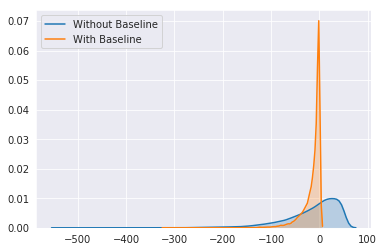

In [0]:
def f_estimator_baseline(x, mean):
  return (-x**2 - (-1 - mean**2)) * (x-mean)

mean2 = 7
sample_size = 10000
x_rand=np.random.normal(mean2, 1, sample_size)
rands_f = f_estimator(x_rand, mean2)
rands_f_baseline = f_estimator_baseline(x_rand, mean2)

import seaborn as sns
sns.set_style('darkgrid')
sns.kdeplot(rands_f, shade=True, label="Without Baseline", legend=True)
sns.kdeplot(rands_f_baseline, shade=True, label="With Baseline", legend=True)

This shows how the addition of the baseline changes the distribution to be a lot *sharper*, which means that it has less variance. The sampling we did above allows us to check our analytic calculations as well: with $\mu=7$, $\text{Var}\left[f(x) (x-\mu)\right] = 3102$ and $\text{Var}\left[\tilde{f}(x) (x-\mu)\right] = 402$. This is similar to what we see with our sampled data:

In [0]:
print("Variance without Baseline: ", np.var(rands_f))
print("Variance with Baseline: ", np.var(rands_f_baseline))

Variance without Baseline:  3191.953232362752
Variance with Baseline:  439.28737878919327


The sample means should be similar (but only the same in the limit $N\to\infty$):

In [0]:
print("Mean without Baseline: ", np.mean(rands_f))
print("Mean with Baseline: ", np.mean(rands_f_baseline))

Mean without Baseline:  -13.739185150112087
Mean with Baseline:  -14.299833759164182


In practice, we don't know the exact mean of $f(x)$ to use as a baseline, but we can just take the sample mean.

**Question**: verify that using `f_estimator_baseline` instead of `f_estimator` in `sf_estimator_variance` reduces the variance

**Extra Reading**
- A great review of score function estimators:
    * [Monte Carlo Gradient Estimation in Machine Learning](https://arxiv.org/abs/1906.10652), Mohamed *et al*, 2019

### Episode Trajectory Collector

Let us implement a function `get_episode_trajectory(env, agent)` that controls the environment `env` with `agent` and returns lists of rewards, observations and actions taken at each timestep:

In [0]:
def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    done = False
    obs = env.reset()
    for _ in range(max_steps):
        observation_list.append(obs)
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]        
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action)
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

Let us try out `get_episode_trajectory` on cartpole using the random agent we implemented earlier:

In [0]:
traj = get_episode_trajectory(env_cartpole, agent_random, max_steps=3)
pprint(traj)

{'Actions': [1, 0, 0],
 'Observations': [array([ 0.04157569, -0.00729371, -0.02744918,  0.02299041]),
                  array([ 0.04142981,  0.18821091, -0.02698937, -0.2782251 ]),
                  array([ 0.04519403, -0.00651582, -0.03255387,  0.00582471])],
 'Rewards': array([1., 1., 1.], dtype=float32)}


### Reward-to-go $\hat{R}_t$

We need to compute the reward-to-go $\hat{R}_t= \sum_{t'=t}^{T} r_{t'}$. Here is a simple NumPy implementation:

In [0]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

Checking that this works as expected:

In [0]:
reward_to_go([1, 1.2, 1])

array([3.2, 2.2, 1. ])

#### Optional extra reading: estimator issues

The estimator $\Phi_t \equiv \hat{R}_t= \sum_{t'=t}^{T} r_{t'}$ we used has a number of problems. For example, if we don't get to the end of an episode (as it takes too long and we stop sampling), or our task is not episodic, we will have incorrect estimates of the advantages of our states. One popular alternative that works around this difficulty is the GAE-Lamba estimator: 
 - [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438), Schulman *et al*, 2015
 - A good blog post on this: https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/

### TensorFlow Policy Net

Let us use a neural net policy with parameters $\theta$, so we have $\pi_\theta(a|s) = NN(s; \theta)$, where $NN(s; \theta)$ is some potentially complex function represented by a neural network with parameters $\theta$:

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [0]:
class AgentMLPTF(Model):
  def __init__(self):
    super(AgentMLPTF, self).__init__()
    self.d1 = Dense(15, activation='tanh')
    self.d2 = Dense(2)

  def call(self, x):
    # 1. Define Policy
    batch = True
    if x.ndim == 1:
        batch = False
        x = np.expand_dims(x, axis=0)
    x = self.d1(x)
    action_logits = self.d2(x)
    
    # 2. Sample policy to get action
    action = tf.random.categorical(action_logits, 1)
    action = action.numpy().flatten()
    if not batch:
        action = np.asscalar(action)
        
    return {"Action":action, "LogProbability":action_logits}

In [0]:
agent_mlp_tf = AgentMLPTF()

In [0]:
obs = np.array([0.1,0.2,0.3,0.4])
agent_mlp_tf(obs)

{'Action': 1,
 'LogProbability': <tf.Tensor: id=829158, shape=(1, 2), dtype=float64, numpy=array([[-0.12512689,  0.09181564]])>}

We can also verify that this works on a batch of observations:


In [0]:
obs_batch = np.array([[0.1,0.2,0.3,0.4], [0.5,0.3,0.2,0.1]])
agent_mlp_tf(obs_batch)

{'Action': array([0, 1]),
 'LogProbability': <tf.Tensor: id=829172, shape=(2, 2), dtype=float64, numpy=
 array([[-0.12512689,  0.09181564],
        [-0.51773388,  0.35831509]])>}

### Loss Function

**Exercise [ALL]**: implement the loss function $\mathcal{L}=\sum_{t=0}^{T}\hat{R}_t\log \pi_\theta(a_t|s_t) $ using TensorFlow operations. Call this function `loss_pg(actions, log_probs, returns)`.

In [0]:
#@title Answer { display-mode: "form" }

def loss_pg(actions, log_probs, returns):
    action_masks = tf.one_hot(actions, 2, dtype=np.float64)
    log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(log_probs), axis=1)
    return -tf.reduce_sum(returns * log_probs)
  
# Verify that this works on some example data:

actions = [1,0,0]
logits = np.array([[0.2,0.8],[0.2,0.8],[0.6,0.4]])
weights = [2.3, 4.3, 2.1]
loss_pg(actions, logits, weights)

# Note: this is equivalent to:
def loss_pg2(actions, log_probs, returns):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    return tf.reduce_mean(returns * loss(actions, log_probs))

### Train the Policy Net

Now we can put all the pieces together in the training loop. It simply collects a single trajectory and uses it to do a single gradient update of the agent:

In [0]:
def train_policy_grad(env, agent, num_epochs=300):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    log_reward = 0
    log_reward_list = []
    logging_period = 20
    
    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]
        
        # compute 'reward-to-go'
        rew_2_go = reward_to_go(rew)
        
        # compute gradients + update weights
        with tf.GradientTape() as tape:
            logits = agent(obs)["LogProbability"]
            loss = loss_pg(actions, logits, rew_2_go)
            
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

Note that `train_policy_grad(env, agent)` takes a TensorFlow agent as input and mutates it during training. Create and train a `AgentMLPTF` agent:

In [0]:
agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env_cartpole, agent_mlp_tf)

Training Epoch 0, Averaged Return: 0.55
Training Epoch 20, Averaged Return: 14.35
Training Epoch 40, Averaged Return: 16.85
Training Epoch 60, Averaged Return: 21.8
Training Epoch 80, Averaged Return: 32.4
Training Epoch 100, Averaged Return: 50.5
Training Epoch 120, Averaged Return: 69.45
Training Epoch 140, Averaged Return: 102.3
Training Epoch 160, Averaged Return: 183.3
Training Epoch 180, Averaged Return: 289.55
Training Epoch 200, Averaged Return: 104.8
Training Epoch 220, Averaged Return: 109.8
Training Epoch 240, Averaged Return: 119.45
Training Epoch 260, Averaged Return: 116.4
Training Epoch 280, Averaged Return: 121.6


We can plot the average rewards obtained versus the number of episodes trained for:

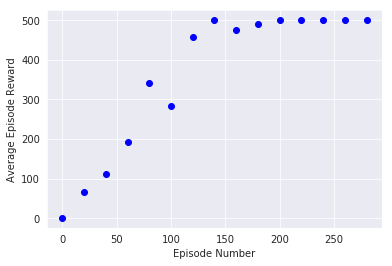

In [0]:
plt.plot(episodes, rewards, 'bo')
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.show()

Let us animate this agent controlling the cartpole environment:

In [0]:
animate_agent(env_cartpole, agent_mlp_tf)

### Policy Gradient Tasks

1. [**ALL**] Try using TensorFlows default initial learning rate of the ADAM optimizer in `train_policy_grad`. What happens? Try come up with an explanation for what is going on.

**Variance Reduction**: We are trying to estimate the policy gradient using $\hat{g} = \frac{1}{|D|}\sum_{\tau \in \mathcal{D}}
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|o_t) 
$. This gradient is only exact if we have an infinite number of samples. Otherwise it is *noisy*: we will get a different estimate of $\hat{g}$ for every sample we take. 

2. [**ALL**] The simplest way of reducing the variance of $\hat{g}$ is to use a *baseline*: rather than using $\hat{R}_t$, use $\hat{R}_t-b$ where $b$ is the mean of $\hat{R}$, i.e. $b=\frac{1}{T}\sum_{t=1}^{T}\hat{R}$. Modify `train_policy_grad` to use this. Does it speed up training? An in-depth discussion of why this works is in the section *Optional extra reading: More on Policy Gradients*.

3. [**Advanced**] The policy used to solve the Cartpole environment only required the most recent observation to inform its actions. Observations taken before the most recent one give no extra information that the policy could use to improve its decision making. This is called the [Markov Property](http://www.cs.cmu.edu/~10601b/slides/MDP_RL.pdf). Most real-world environments are not like this. Consider the problem of using a reinforcement learning agent to control a self-driving car, where an observation is a frame from its onboard video cameras. List various ways in which the Markov Property is violated in this environment (this is also known as a *partially-observed environment*). How might you modify the architecture of your policy net to operate in a non-Markovian environment like this?

**IMPORTANT: Please fill out the exit ticket form before you leave the practical: https://tinyurl.com/yxjvqx5k**

### Optional extra reading: Policy Gradients



- The simple REINFORCE algorithm shown here is very unstable. There are a number of improvements to this method, the most popular of which is probably PPO:
    * [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347), Schulman *et al*, 2017
    * OpenAI SpinningUp: https://spinningup.openai.com/en/latest/algorithms/ppo.html
    * OpenAI Blog: https://openai.com/blog/openai-baselines-ppo/
- PPO borrows many ideas from TRPO. [Depth First Learning](https://www.depthfirstlearning.com/2018/TRPO) has a course with a lot of good resources on TRPO.
- The idea of being able to differentiate through stochastic nodes in computation graphs is a very powerful idea, and it is used in a number of other areas in deep learning, such as *variational autoencoders*. 
    * For the general setting, see [Gradient Estimation Using Stochastic Computation Graphs](https://arxiv.org/abs/1506.05254), Schulman *et al*, 2015.
- For a skeptical take on policy gradients, see Ben Recht's post [The Policy of Truth](https://www.argmin.net/2018/02/20/reinforce/).
- Karpathy has [good post](http://karpathy.github.io/2016/05/31/rl/) on reinforcement learning using policy gradients, including an implementation of policy gradients that solves Pong using only NumPy in [131 lines of Python](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)! 